## TradingEnv-v0

### Open AI 'Gym' for reinforcement-learning based trading algorithms

This gym implements a very simple trading environment for reinforcement learning.

The gym provides daily observations based on real market data pulled from Quandl on, by default, the SPY etf.  An episode is defined as 252 contiguous days sampled from the overall dataset.  Each day is one 'step' within the gym and for each step, the algo has a choice:

 - SHORT (0)
 - FLAT (1)
 - LONG  (2)
 
If you trade, you will be charged, by default, 10 BPS of the size of your trade.  Thus, going from short to long costs twice as much as going from short to/from flat.  Not trading also has a default cost of 1 BPS per step.  Nobody said it would be easy!
 
At the beginning of your episode, you are allocated 1 unit of cash.  This is your starting Net Asset Value (NAV). 

### Beating the trading game 

For our purposes, we'll say that beating a buy & hold strategy, on average, over one hundred episodes will notch a win to the proud ai player.  We'll illustrate exactly what that means below.

### Let's look at some code using the environment


###  imports

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import gym_trading


### create the environment

This may take a moment as we are pulling historical data from quandl.

In [2]:
env = gym.make('trading-v0')
#env.time_cost_bps = 0 # 


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Environment '<class 'gym_trading.envs.trading_env.TradingEnv'>' has deprecated methods. Compatibility code invoked.


### the trading model

Each time step is a day.  Each episode is 252 trading days - a year.  Each day, we can choose to be short (0), flat (1) or long (2) the single instrument in our trading universe.

Let's run through a day and stay flat.

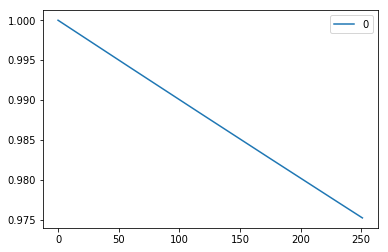

In [3]:
observation = env.reset()
done = False
navs = []
while not done:
    action = 1 # stay flat
    observation, reward, done, info = env.step(action)
    navs.append(info['nav'])
    if done:
        #print 'Annualized return: ',navs[len(navs)-1]-1
        pd.DataFrame(navs).plot()


### Note that you are charged just for playing - to the tune of 1 basis point per day!


### Rendering

For now, no rendering has been implemented for this gym, but with each step, the following datum are provided which you can easily graph and otherwise visualize as we see above with the NAV:

 - pnl - how much did we make or lose between yesterday and today?
 - costs  - how much did we pay in costs today
 - nav    - our current nav
 

## utility methods: running strategies once or repeatedly

Although the gym can be 'exercised' directly as seen above, we've also written utility methods which allow for the running of a strategy once or over many episodes, facilitating training or other sorts of analysis.

To utilize these methods, strategies should be exposed as a function or lambda with the following signature:

`Action a = strategy( observation, environment )`
    
Below, we define some simple strategies and look briefly at their behavior to better understand the trading gym. 

   action   bod_nav   mkt_nav  mkt_return  sim_return  position   costs  trade
0     2.0  1.000000  1.000000   -0.018933   -0.001100       1.0  0.0011    1.0
1     2.0  0.998900  0.981067    0.008772    0.008672       1.0  0.0001    0.0
2     2.0  1.007562  0.989673    0.003478    0.003378       1.0  0.0001    0.0
3     2.0  1.010966  0.993115   -0.010399   -0.010499       1.0  0.0001    0.0
4     2.0  1.000352  0.982788   -0.001751   -0.001851       1.0  0.0001    0.0


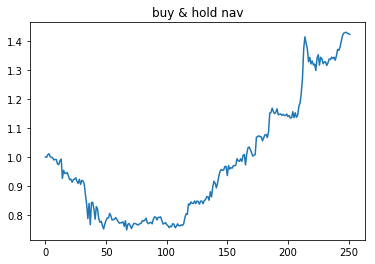

In [4]:
import trading_env as te

stayflat     = lambda o,e: 1   # stand pat
buyandhold   = lambda o,e: 2   # buy on day #1 and hold
randomtrader = lambda o,e: e.action_space.sample() # retail trader

# to run singly, we call run_strat.  we are returned a dataframe containing 
#  all steps in the sim.
env = env.unwrapped
bhdf = env.run_strat(buyandhold)

print(bhdf.head())

# we can easily plot our nav in time:
bhdf.bod_nav.plot(title='buy & hold nav')


### running the same strategy multiple times will likely yield different results as underlying data changes

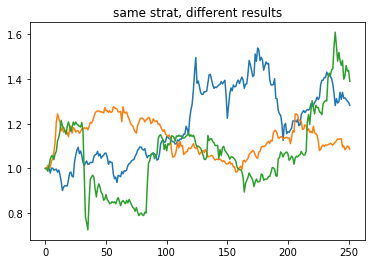

In [5]:
env.run_strat(buyandhold).bod_nav.plot(title='same strat, different results')
env.run_strat(buyandhold).bod_nav.plot()
env.run_strat(buyandhold).bod_nav.plot()

### comparing the buyandhold and random traders

In [6]:
# running a strategy multiple times should yield insights 
#   into its expected behavior or give it oppty to learn
bhdf = env.run_strats(buyandhold,100)
rdf = env.run_strats(randomtrader,100)

comparo = pd.DataFrame({'buyhold':bhdf.mean(),
                        'random': rdf.mean()})
comparo

,buyhold,random
action,2.000000,0.997063
bod_nav,1.033394,0.884085
mkt_nav,1.050317,1.092891
mkt_return,0.000536,0.000807
sim_return,0.000419,-0.001033
position,1.000000,-0.002937
costs,0.000104,0.000987
trade,0.003968,0.000159


## Object of the game

From the above examples, we can see that buying and holding will, over the long run, give you the market return with low costs.

Randomly trading will instead destroy value rather quickly as costs overwhelm.

### So, what does it mean to win the trading game?  

For our purposes, we'll say that beating a buy & hold strategy, on average, over one hundred episodes will notch a win to the proud ai player.

To support this, the trading environment maintains the *mkt_return* which can be compared with the *sim_return*.

Note that the *mkt_return* is frictionless while the *sim_return* incurs both trading costs and the decay cost of 1 basis point per day, so overcoming the hurdle we've set here should be challenging.


### Playing the game: purloined policy gradients

I've taken and adapted (see [code](policy_gradient.py) for details) a policy gradient implementation based on tensorflow to try to play the single-instrument trading game.  Let's see how it does.

In [7]:
import tensorflow as tf
import policy_gradient

/Users/colinsmith/miniconda3/envs/personal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
INFO:policy_gradient:policy_gradient logger started.


In [8]:
# create the tf session
sess = tf.InteractiveSession()

# create policygradient
pg = policy_gradient.PolicyGradient(sess, obs_dim=5, num_actions=3, learning_rate=1e-2 )

# and now let's train it and evaluate its progress.  NB: this could take some time...
df,sf = pg.train_model(env, episodes=25001, log_freq=100)#, load_model=True)


INFO:policy_gradient:year #     0, mean reward:   0.0006, sim ret:   0.0320, mkt ret:  -0.3905, net:   0.4225
INFO:policy_gradient:year #   100, mean reward:   0.0663, sim ret:   0.4581, mkt ret:   0.5076, net:  -0.0494
INFO:policy_gradient:year #   200, mean reward:   0.0718, sim ret:   0.0864, mkt ret:   0.0823, net:   0.0041
INFO:policy_gradient:year #   300, mean reward:   0.1426, sim ret:   0.1188, mkt ret:   0.1436, net:  -0.0249
INFO:policy_gradient:year #   400, mean reward:   0.1205, sim ret:  -0.0573, mkt ret:  -0.0006, net:  -0.0567
INFO:policy_gradient:year #   500, mean reward:   0.1411, sim ret:  -0.1806, mkt ret:  -0.1409, net:  -0.0397
INFO:policy_gradient:year #   600, mean reward:   0.1427, sim ret:   0.0630, mkt ret:   0.0881, net:  -0.0251
INFO:policy_gradient:year #   700, mean reward:   0.1274, sim ret:   0.3737, mkt ret:   0.4343, net:  -0.0606
INFO:policy_gradient:year #   800, mean reward:   0.1318, sim ret:  -0.1249, mkt ret:  -0.0722, net:  -0.0527
INFO:polic

### Results

Policy gradients beat the trading game!  That said, it doesn't work every time and it seems, looking at the charts below, as though it's a bit of a lucky thing.  But luck counts in the trading game as in life!


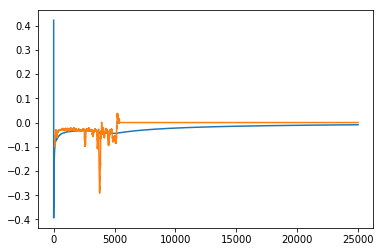

In [9]:
sf['net'] = sf.simror - sf.mktror
#sf.net.plot()
sf.net.expanding().mean().plot()
sf.net.rolling(100).mean().plot()

In [10]:
sf.net.rolling(100).mean().tail()

24996    1.931788e-16
24997    1.931788e-16
24998    1.931788e-16
24999    1.931788e-16
25000    1.931788e-16
Name: net, dtype: float64